# VibeQ – Deberta-v3-large Emotion Classifier

HF Trainer + Focal loss


## Environment setup
Install transformers, datasets, accelerate, and evaluate.

In [ ]:
!pip install -q transformers datasets accelerate evaluate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00


In [1]:
!pip install -U transformers datasets accelerate evaluate


## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Model paths
Set the base checkpoint and output directory.

In [3]:
MODEL_NAME = "microsoft/deberta-v3-large"
OUTPUT_DIR = "/content/drive/MyDrive/VibeQ-EIE/models"

## Core imports

In [4]:
import numpy as np
import torch
from torch import nn

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from transformers.modeling_outputs import SequenceClassifierOutput

from sklearn.metrics import f1_score
import random
import os


## Reproducibility
Seed numpy, torch, and random for stable runs.

In [5]:
SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## Load GoEmotions dataset

In [6]:
from datasets import load_dataset

# This will download GoEmotions from HF Hub
dataset = load_dataset("go_emotions", "simplified")
dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

## Label space
Extract the label names and count.

In [7]:
label_names = dataset["train"].features["labels"].feature.names
num_labels = len(label_names)
label_names, num_labels


(['admiration',
  'amusement',
  'anger',
  'annoyance',
  'approval',
  'caring',
  'confusion',
  'curiosity',
  'desire',
  'disappointment',
  'disapproval',
  'disgust',
  'embarrassment',
  'excitement',
  'fear',
  'gratitude',
  'grief',
  'joy',
  'love',
  'nervousness',
  'optimism',
  'pride',
  'realization',
  'relief',
  'remorse',
  'sadness',
  'surprise',
  'neutral'],
 28)

## Clean noisy rows
Drop very unclear examples if present.

In [8]:
for split in ["train", "validation", "test"]:
    if "example_very_unclear" in dataset[split].column_names:
        dataset[split] = dataset[split].filter(lambda x: x["example_very_unclear"] == 0)


## Tokenization
Encode text to fixed-length inputs.

In [9]:
MAX_LENGTH = 192  # can try 192 later if GPU allows

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode_batch(batch):
    # Tokenize text
    enc = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )
    # Multi-hot encode labels
    labels_multi = np.zeros((len(batch["labels"]), num_labels), dtype=np.float32)
    for i, lbls in enumerate(batch["labels"]):
        for lab in lbls:
            labels_multi[i, lab] = 1.0
    enc["labels"] = labels_multi
    return enc

encoded_dataset = dataset.map(
    encode_batch,
    batched=True,
    remove_columns=[col for col in dataset["train"].column_names if col not in ["text", "labels"]],
)

encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

train_ds = encoded_dataset["train"]
val_ds   = encoded_dataset["validation"]
test_ds  = encoded_dataset["test"]

len(train_ds), len(val_ds), len(test_ds)


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

(43410, 5426, 5427)

## Focal loss
Loss tailored for imbalance.

In [10]:
import torch
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        logits: [B, C] raw logits
        targets: [B, C] float tensor in {0,1}
        """
        bce_loss = F.binary_cross_entropy_with_logits(
            logits,
            targets,
            reduction="none"
        )

        probs = torch.sigmoid(logits)
        pt = targets * probs + (1 - targets) * (1 - probs)

        focal_factor = (1 - pt) ** self.gamma
        loss = focal_factor * bce_loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss


## Model wrapper
DeBERTa with focal loss head.

In [15]:
class DebertaForMultiLabel(torch.nn.Module):
    def __init__(self, model_name, num_labels, gamma=2.0):
        super().__init__()
        self.base_model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            problem_type="multi_label_classification",
        )
        self.loss_fct = FocalLoss(gamma=gamma)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        **kwargs,
    ):
        # Drop extra args that Trainer / accelerate may pass
        kwargs.pop("num_items_in_batch", None)

        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None,  # we handle loss ourselves
            **kwargs,
        )

        logits = outputs.logits
        loss = None

        if labels is not None:
            labels = labels.float()
            loss = self.loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


## Metrics
Compute multi-label F1 and ROC AUC.

In [16]:
from sklearn.metrics import f1_score

THRESHOLD_METRIC = 0.3  # can tune later

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    labels = labels.astype(np.float32)

    # logits → probabilities
    probs = 1 / (1 + np.exp(-logits))  # sigmoid

    preds = (probs > THRESHOLD_METRIC).astype(int)

    # flatten according to sklearn expectations
    f1_micro = f1_score(labels, preds, average="micro", zero_division=0)
    f1_macro = f1_score(labels, preds, average="macro", zero_division=0)

    return {
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
    }


## Training setup
Define Trainer arguments and output paths.

In [17]:
from pathlib import Path

OUTPUT_DIR = Path("/content/drive/MyDrive/VibeQ-EIE/models")
model_output_dir = OUTPUT_DIR / "HF_deberta_goemotions_focal_v1"

training_args = TrainingArguments(
    output_dir=str(model_output_dir),
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    warmup_ratio=0.1,

    eval_strategy="epoch",

    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    save_total_limit=2,
)


gamma = 1.5

model = DebertaForMultiLabel(
    model_name=MODEL_NAME,
    num_labels=num_labels,
    gamma=gamma,
).to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3852535335.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Train baseline model

In [18]:
train_result = trainer.train()
train_result


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.032100,0.032024,0.548261,0.462745
2,0.028700,0.030048,0.568565,0.501936
3,0.023400,0.031257,0.571264,0.520643
4,0.017200,0.034775,0.573153,0.519895


TrainOutput(global_step=10856, training_loss=0.029927284705919998, metrics={'train_runtime': 5284.3487, 'train_samples_per_second': 32.859, 'train_steps_per_second': 2.054, 'total_flos': 0.0, 'train_loss': 0.029927284705919998, 'epoch': 4.0})

## Validate on dev split

In [19]:
metrics = trainer.evaluate(eval_dataset=val_ds)
metrics


{'eval_loss': 0.03477456420660019,
 'eval_f1_micro': 0.5731532393019364,
 'eval_f1_macro': 0.5198954977753731,
 'eval_runtime': 47.1417,
 'eval_samples_per_second': 115.1,
 'eval_steps_per_second': 3.606,
 'epoch': 4.0}

## Save checkpoint

In [20]:
trainer.save_model(str(model_output_dir))
tokenizer.save_pretrained(str(model_output_dir))



('/content/drive/MyDrive/VibeQ-EIE/models/HF_deberta_goemotions_focal_v1/tokenizer_config.json',
 '/content/drive/MyDrive/VibeQ-EIE/models/HF_deberta_goemotions_focal_v1/special_tokens_map.json',
 '/content/drive/MyDrive/VibeQ-EIE/models/HF_deberta_goemotions_focal_v1/spm.model',
 '/content/drive/MyDrive/VibeQ-EIE/models/HF_deberta_goemotions_focal_v1/added_tokens.json',
 '/content/drive/MyDrive/VibeQ-EIE/models/HF_deberta_goemotions_focal_v1/tokenizer.json')

## Threshold tuning on validation

In [21]:
# Get raw logits & labels on validation set
val_logits, val_labels = trainer.predict(val_ds)[:2]  # (predictions, label_ids, metrics)
val_labels = val_labels.astype(np.float32)

val_probs = 1 / (1 + np.exp(-val_logits))  # sigmoid

thresholds = np.linspace(0.05, 0.5, 10)
best_micro, best_macro, best_thr_micro, best_thr_macro = 0, 0, None, None

for thr in thresholds:
    preds = (val_probs > thr).astype(int)
    f1_micro = f1_score(val_labels, preds, average="micro", zero_division=0)
    f1_macro = f1_score(val_labels, preds, average="macro", zero_division=0)
    print(f"Threshold {thr:.2f} | micro={f1_micro:.4f} | macro={f1_macro:.4f}")

    if f1_micro > best_micro:
        best_micro = f1_micro
        best_thr_micro = thr
    if f1_macro > best_macro:
        best_macro = f1_macro
        best_thr_macro = thr

print("\nBest for micro F1:")
print("  thr =", best_thr_micro, "F1_micro =", best_micro)

print("\nBest for macro F1:")
print("  thr =", best_thr_macro, "F1_macro =", best_macro)


Threshold 0.05 | micro=0.1989 | macro=0.1634
Threshold 0.10 | micro=0.3443 | macro=0.2998
Threshold 0.15 | micro=0.4393 | macro=0.3907
Threshold 0.20 | micro=0.5013 | macro=0.4483
Threshold 0.25 | micro=0.5439 | macro=0.4945
Threshold 0.30 | micro=0.5732 | macro=0.5199
Threshold 0.35 | micro=0.5910 | macro=0.5348
Threshold 0.40 | micro=0.5993 | macro=0.5446
Threshold 0.45 | micro=0.6005 | macro=0.5403
Threshold 0.50 | micro=0.5970 | macro=0.5264

Best for micro F1:
  thr = 0.45 F1_micro = 0.6004633204633205

Best for macro F1:
  thr = 0.4 F1_macro = 0.5445681507756811


## Apply best threshold and test

In [22]:
best_thr = best_thr_micro  # or choose manually

test_logits, test_labels = trainer.predict(test_ds)[:2]
test_labels = test_labels.astype(np.float32)
test_probs = 1 / (1 + np.exp(-test_logits))

test_preds = (test_probs > best_thr).astype(int)

test_f1_micro = f1_score(test_labels, test_preds, average="micro", zero_division=0)
test_f1_macro = f1_score(test_labels, test_preds, average="macro", zero_division=0)

print(f"Test F1-micro (thr={best_thr:.2f}): {test_f1_micro:.4f}")
print(f"Test F1-macro (thr={best_thr:.2f}): {test_f1_macro:.4f}")


Test F1-micro (thr=0.45): 0.6063
Test F1-macro (thr=0.45): 0.5515


### Map to 9 emotions

## 9-label remap setup
Reload dataset and tokenizer for 9 emotions.

In [3]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# 1. Setup the new 9-label configuration
MAX_LENGTH = 192
TARGET_LABELS = [
    "anger", "anticipation", "caring", "disgust", "fear",
    "joy", "neutral", "sadness", "surprise"
]
# Create lookups for the NEW 9 targets
label2id = {label: idx for idx, label in enumerate(TARGET_LABELS)}
id2label = {idx: label for idx, label in enumerate(TARGET_LABELS)}
NUM_LABELS = len(TARGET_LABELS) # = 9

# 2. Define the Map from OLD (GoEmotions) -> NEW (9 Targets)
# (Using the string names to be safe, assuming your fresh dataset has integer labels)
original_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval",
    "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
    "joy", "love", "nervousness", "optimism", "pride", "realization",
    "relief", "remorse", "sadness", "surprise", "neutral"
]
# Map index-to-string for the original dataset so we can look them up
orig_id2label = {i: name for i, name in enumerate(original_labels)}

EMOTION_MAP = {
    "anger": "anger", "annoyance": "anger", "disapproval": "anger",
    "optimism": "anticipation", "curiosity": "anticipation", "desire": "anticipation",
    "caring": "caring", "love": "caring", "admiration": "caring", "gratitude": "caring", "approval": "caring",
    "disgust": "disgust",
    "fear": "fear", "nervousness": "fear",
    "joy": "joy", "excitement": "joy", "amusement": "joy", "pride": "joy", "relief": "joy",
    "neutral": "neutral",
    "sadness": "sadness", "disappointment": "sadness", "grief": "sadness", "remorse": "sadness", "embarrassment": "sadness",
    "surprise": "surprise", "confusion": "surprise", "realization": "surprise"
}

# 3. Load Tokenizer & Existing Model Path
# Replace this with the path to your 4-epoch trained model
MODEL_PATH = "/content/drive/MyDrive/VibeQ-EIE/models/deberta_goemotions_28labels_clean"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

print(f"Targeting {len(TARGET_LABELS)} emotions: {TARGET_LABELS}")

The tokenizer you are loading from '/content/drive/MyDrive/VibeQ-EIE/models/deberta_goemotions_28labels_clean' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Targeting 9 emotions: ['anger', 'anticipation', 'caring', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


## Clean and prepare splits

In [4]:
dataset = load_dataset("go_emotions", "simplified")

for split in ["train", "validation", "test"]:
    if "example_very_unclear" in dataset[split].column_names:
        dataset[split] = dataset[split].filter(lambda x: x["example_very_unclear"] == 0)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

## Tokenize and remap labels

In [5]:
def process_and_map(batch):
    # --- Part A: Text Encoding ---
    tokenized = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=192
    )

    # --- Part B: Label Mapping (The Critical Step) ---
    # Prepare empty matrix: [batch_size, 9]
    new_labels = np.zeros((len(batch["labels"]), 9), dtype=np.float32)

    for i, old_indices in enumerate(batch["labels"]):
        for old_idx in old_indices:
            # 1. Get the original name (e.g., "optimism")
            original_name = orig_id2label[old_idx]

            # 2. Find which of the 9 buckets it belongs to (e.g., "anticipation")
            if original_name in EMOTION_MAP:
                target_label = EMOTION_MAP[original_name]

                # 3. Get the ID for that bucket (e.g., index 1)
                target_idx = label2id[target_label]

                # 4. Mark it as present
                new_labels[i, target_idx] = 1.0

    tokenized["labels"] = new_labels
    return tokenized

# 3. APPLY IT
encoded_dataset = dataset.map(
    process_and_map,
    batched=True,
    remove_columns=dataset["train"].column_names # Removes old text/label cols
)

encoded_dataset.set_format("torch")

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

## 9-label metrics

In [11]:
THRESHOLD_METRIC = 0.3
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    labels = labels.astype(np.float32)

    # logits → probabilities
    probs = 1 / (1 + np.exp(-logits))  # sigmoid

    preds = (probs > THRESHOLD_METRIC).astype(int)

    # flatten according to sklearn expectations
    f1_micro = f1_score(labels, preds, average="micro", zero_division=0)
    f1_macro = f1_score(labels, preds, average="macro", zero_division=0)

    return {
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
    }

## Train/val/test datasets

In [12]:
train_ds = encoded_dataset["train"]
val_ds   = encoded_dataset["validation"]
test_ds  = encoded_dataset["test"]

## 9-label focal model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import DebertaV2ForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput

class FocalLoss(nn.Module):
    def __init__(self, gamma: float = 2.0, reduction: str = "mean"):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # logits: [B, C], targets: [B, C] in {0,1}
        bce = F.binary_cross_entropy_with_logits(
            logits,
            targets,
            reduction="none",
        )
        probs = torch.sigmoid(logits)
        pt = targets * probs + (1 - targets) * (1 - probs)
        focal = (1 - pt) ** self.gamma * bce

        if self.reduction == "mean":
            return focal.mean()
        if self.reduction == "sum":
            return focal.sum()
        return focal


class DebertaV3MultiLabelFocal(DebertaV2ForSequenceClassification):
    def __init__(self, config, gamma: float = 1.5, **kwargs):
        super().__init__(config)
        self.focal_loss = FocalLoss(gamma=gamma)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        **kwargs,
    ):
        kwargs.pop("num_items_in_batch", None)

        # Let the parent compute logits etc., but no built-in loss
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None,      # we handle loss ourselves
            **kwargs,
        )

        logits = outputs.logits
        loss = None

        if labels is not None:
            labels = labels.float()          # ensure correct dtype
            loss = self.focal_loss(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


## Two-stage training: head then full body

In [14]:
# --- STEP 1: INITIALIZE WITH NEW HEAD ---
print("Loading model with FocalLoss and replacing head...")
model = DebertaV3MultiLabelFocal.from_pretrained(
    MODEL_PATH,
    num_labels=len(TARGET_LABELS),          # 9
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True,          # 28 -> 9 head
    gamma=1.5,
)



Loading model with FocalLoss and replacing head...


Some weights of DebertaV3MultiLabelFocal were not initialized from the model checkpoint at /content/drive/MyDrive/VibeQ-EIE/models/deberta_goemotions_28labels_clean and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([28, 1024]) in the checkpoint and torch.Size([9, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# --- STEP 2: FREEZE BODY (Train Head Only) ---
print("Step 1: Freezing DeBERTa body...")
for param in model.deberta.parameters():
    param.requires_grad = False

training_args_head = TrainingArguments(
    output_dir="./results_stage1_head_only",
    learning_rate=1e-3, # Higher LR for fresh head
    per_device_train_batch_size=16,
    num_train_epochs=1, # Quick alignment
    save_strategy="no",
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args_head,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

trainer.train()
print("Head alignment complete.")

Step 1: Freezing DeBERTa body...


Step,Training Loss
50,0.078300
100,0.048000
150,0.044200
200,0.051100
250,0.049000
300,0.048500
350,0.051000
400,0.044200
450,0.042800
500,0.046200


Head alignment complete.


In [16]:

# --- STEP 3: UNFREEZE BODY (Fine-Tune All) ---
print("Step 2: Unfreezing body for final tuning...")
for param in model.deberta.parameters():
    param.requires_grad = True

training_args_full = TrainingArguments(
    output_dir="./results_final_9_emotions",
    learning_rate=5e-6, # VERY LOW LR to preserve previous knowledge
    per_device_train_batch_size=8, # Smaller batch size if memory is tight
    gradient_accumulation_steps=2,
    num_train_epochs=2, # 1-2 epochs is usually enough
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro"
)

trainer = Trainer(
    model=model,
    args=training_args_full,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

trainer.train()

print("Training complete!")

Step 2: Unfreezing body for final tuning...


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.067200,0.106303,0.651358,0.607057
2,0.053500,0.119678,0.647768,0.601338


Training complete!


## Validate remapped model

In [17]:
metrics = trainer.evaluate(eval_dataset=val_ds)
metrics

{'eval_loss': 0.10630292445421219,
 'eval_f1_micro': 0.6513575766036156,
 'eval_f1_macro': 0.6070572653703442,
 'eval_runtime': 127.3237,
 'eval_samples_per_second': 42.616,
 'eval_steps_per_second': 5.333,
 'epoch': 2.0}

## Tune threshold on remapped validation set

In [18]:
# Get raw logits & labels on validation set
val_logits, val_labels = trainer.predict(val_ds)[:2]  # (predictions, label_ids, metrics)
val_labels = val_labels.astype(np.float32)

val_probs = 1 / (1 + np.exp(-val_logits))  # sigmoid

thresholds = np.linspace(0.05, 0.5, 10)
best_micro, best_macro, best_thr_micro, best_thr_macro = 0, 0, None, None

for thr in thresholds:
    preds = (val_probs > thr).astype(int)
    f1_micro = f1_score(val_labels, preds, average="micro", zero_division=0)
    f1_macro = f1_score(val_labels, preds, average="macro", zero_division=0)
    print(f"Threshold {thr:.2f} | micro={f1_micro:.4f} | macro={f1_macro:.4f}")

    if f1_micro > best_micro:
        best_micro = f1_micro
        best_thr_micro = thr
    if f1_macro > best_macro:
        best_macro = f1_macro
        best_thr_macro = thr

print("\nBest for micro F1:")
print("  thr =", best_thr_micro, "F1_micro =", best_micro)

print("\nBest for macro F1:")
print("  thr =", best_thr_macro, "F1_macro =", best_macro)

Threshold 0.05 | micro=0.4086 | macro=0.3537
Threshold 0.10 | micro=0.5241 | macro=0.4683
Threshold 0.15 | micro=0.5848 | macro=0.5315
Threshold 0.20 | micro=0.6184 | macro=0.5691
Threshold 0.25 | micro=0.6367 | macro=0.5909
Threshold 0.30 | micro=0.6514 | macro=0.6071
Threshold 0.35 | micro=0.6571 | macro=0.6146
Threshold 0.40 | micro=0.6602 | macro=0.6170
Threshold 0.45 | micro=0.6598 | macro=0.6197
Threshold 0.50 | micro=0.6564 | macro=0.6173

Best for micro F1:
  thr = 0.4 F1_micro = 0.6601701469450889

Best for macro F1:
  thr = 0.45 F1_macro = 0.6196914628774712


## Save 9-label checkpoint

In [20]:
import os
from pathlib import Path
OUTPUT_DIR = Path("/content/drive/MyDrive/VibeQ-EIE/models")
model_output_dir = OUTPUT_DIR / "HF_deberta_goemotions_focal_v1_9emmotions"
os.makedirs(model_output_dir, exist_ok=True)

trainer.save_model(str(model_output_dir))
tokenizer.save_pretrained(str(model_output_dir))

('/content/drive/MyDrive/VibeQ-EIE/models/HF_deberta_goemotions_focal_v1_9emmotions/tokenizer_config.json',
 '/content/drive/MyDrive/VibeQ-EIE/models/HF_deberta_goemotions_focal_v1_9emmotions/special_tokens_map.json',
 '/content/drive/MyDrive/VibeQ-EIE/models/HF_deberta_goemotions_focal_v1_9emmotions/spm.model',
 '/content/drive/MyDrive/VibeQ-EIE/models/HF_deberta_goemotions_focal_v1_9emmotions/added_tokens.json',
 '/content/drive/MyDrive/VibeQ-EIE/models/HF_deberta_goemotions_focal_v1_9emmotions/tokenizer.json')

## Test evaluation

In [21]:
best_thr = best_thr_micro  # or choose manually

test_logits, test_labels = trainer.predict(test_ds)[:2]
test_labels = test_labels.astype(np.float32)
test_probs = 1 / (1 + np.exp(-test_logits))

test_preds = (test_probs > best_thr).astype(int)

test_f1_micro = f1_score(test_labels, test_preds, average="micro", zero_division=0)
test_f1_macro = f1_score(test_labels, test_preds, average="macro", zero_division=0)

print(f"Test F1-micro (thr={best_thr:.2f}): {test_f1_micro:.4f}")
print(f"Test F1-macro (thr={best_thr:.2f}): {test_f1_macro:.4f}")

Test F1-micro (thr=0.40): 0.6608
Test F1-macro (thr=0.40): 0.6232


## Additional test predictions

In [23]:
pred_output = trainer.predict(test_ds)

# Extract logits and labels
test_logits = pred_output.predictions
test_labels = pred_output.label_ids

# If logits come as tuple
if isinstance(test_logits, tuple):
    test_logits = test_logits[0]

print(test_logits.shape, test_labels.shape)


(5427, 9) (5427, 9)


## Classification report

In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Convert logits → probabilities → predictions
test_labels = test_labels.astype(np.float32)
test_probs  = 1 / (1 + np.exp(-test_logits))  # sigmoid
test_preds  = (test_probs > best_thr).astype(int)

print("Shapes:", test_labels.shape, test_preds.shape)

# Build per-class metrics
report_dict = classification_report(
    test_labels,
    test_preds,
    target_names=TARGET_LABELS,   # 9 labels
    zero_division=0,
    output_dict=True              # <-- so we can put into a DataFrame
)

# Keep only the individual labels (no 'micro avg', etc.)
rows = []
for label in TARGET_LABELS:
    m = report_dict[label]
    rows.append({
        "label": label,
        "precision": m["precision"],
        "recall": m["recall"],
        "f1": m["f1-score"],
        "support": m["support"],
    })

df_per_class = pd.DataFrame(rows).sort_values("label").reset_index(drop=True)
df_per_class


Shapes: (5427, 9) (5427, 9)


,label,precision,recall,f1,support
0,anger,0.512987,0.652893,0.574545,726.0
1,anticipation,0.534056,0.638889,0.581788,540.0
2,caring,0.737846,0.821233,0.777310,1460.0
3,disgust,0.521739,0.487805,0.504202,123.0
4,fear,0.632479,0.755102,0.688372,98.0
5,joy,0.678161,0.774859,0.723292,533.0
6,neutral,0.650313,0.697258,0.672968,1787.0
7,sadness,0.551111,0.654354,0.598311,379.0
8,surprise,0.461538,0.518692,0.488449,428.0


## Confusion matrices

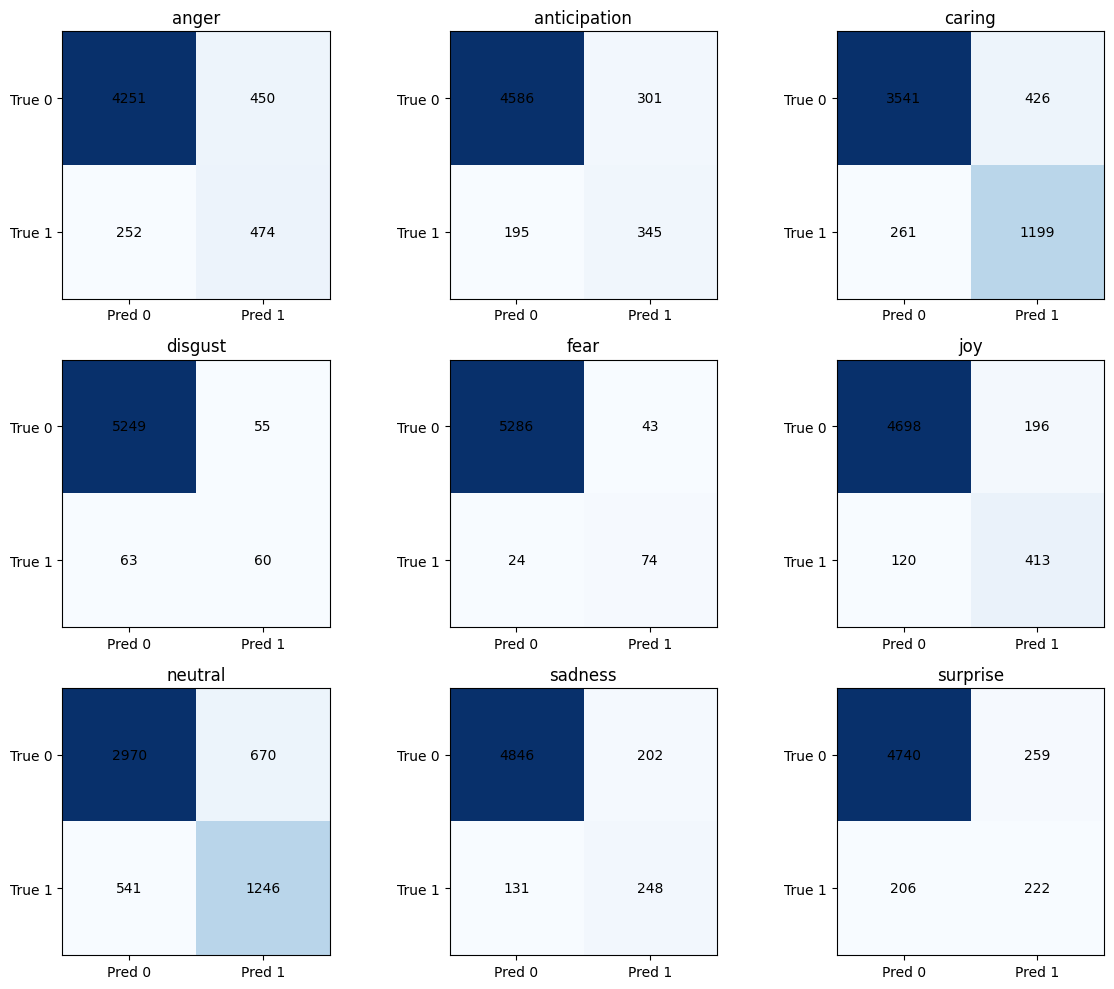

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Ensure we use the same preds as above
test_cm = multilabel_confusion_matrix(test_labels, test_preds)  # shape: [C, 2, 2]

num_labels = len(TARGET_LABELS)
n_rows, n_cols = 3, 3   # for 9 labels

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))

for idx, label in enumerate(TARGET_LABELS):
    r = idx // n_cols
    c = idx % n_cols
    ax = axes[r, c]

    cm = test_cm[idx]  # 2x2
    im = ax.imshow(cm, cmap="Blues")

    ax.set_title(label)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])

    # Annotate values
    for i in range(2):
        for j in range(2):
            ax.text(
                j, i, int(cm[i, j]),
                ha="center", va="center",
                color="black", fontsize=10
            )

# Remove any unused subplots if num_labels < n_rows * n_cols
for idx in range(num_labels, n_rows * n_cols):
    r = idx // n_cols
    c = idx % n_cols
    fig.delaxes(axes[r, c])

fig.tight_layout()
plt.show()
